In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Audio
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

USE_CPU = False

if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")

    device = torch.device("cuda:0")

if USE_CPU:
    device = "cpu"


Using: AMD Radeon RX 6700 XT


In [3]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)


In [4]:
selected_language = "nl"
idxs = np.where(y_train == language_dict[selected_language])[0]
idx = np.random.choice(idxs)

Audio(X_train[idx], rate=sampling_rate)


### Question 1
The dataset consists of individual waveforms. These contain the shape of the sound signal over time.
Because our audio clips are digital, the waveforms consist of sound amplitude at invidual timesteps.
The clips here are sampled at 8 kilohertz (khz), meaning there are 8000 amplitude measurements for
every second. Each audio clip is 5 seconds long. Each audio clip has 8000 · 5 = 40000 measurements
in total.

**Question 1a:** With this in mind, plot the waveforms of 5 randomly selected samples
from the training set. Make sure that for each image, the y-axis has the same limits.

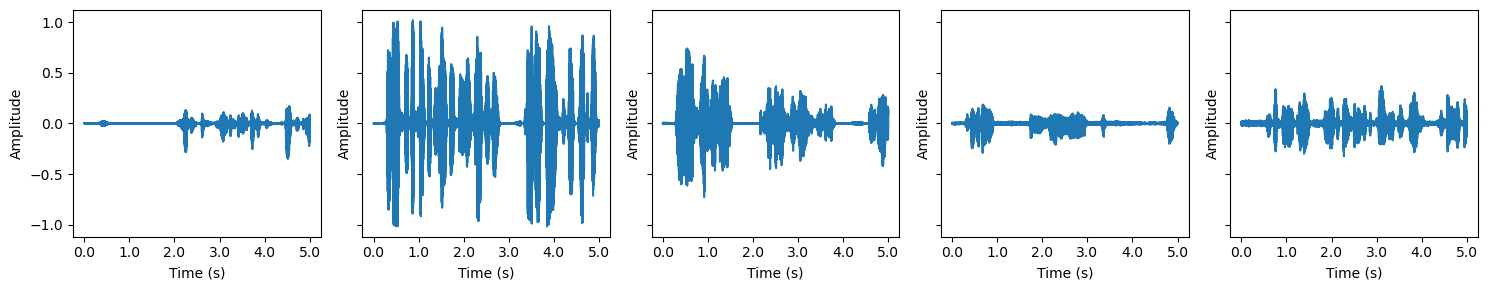

In [5]:
idxs = np.random.choice(X_train.shape[0], size=5, replace=False)
fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

for i, ax in enumerate(axs.flatten()):
    ax.plot(X_train[idxs[i]])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    # ax.set_xticklabels([])
    ax.set_xticks(np.linspace(0, 40_000, 6))
    ax.set_xticklabels(np.linspace(0, 5, 6))

plt.tight_layout()
fig.savefig("waveforms.png")


Apart from the number/pattern of peaks, there is a marked difference between the plots.
This difference has nothing to do with the language being spoken. Explain the difference in one sen-
tence. In addition, explain what normalization step can be taken to prevent a model from overfitting
on this difference in two sentences or less.

**Question 1b:** Perform normalization and transformation of the input data. In tutori-
als, we have seen a basic way to perform data normalization. We can take this step. In addition, take
the normalization step you discussed in Question 1a.

#### Answer

* The volume is different across samples. Since the volume of the track should not be informative of the language, we want to normalize all clips to the same average volume.

In [25]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean))
        self.register_buffer("std", torch.tensor(std))

    def forward(self, x):
        with torch.no_grad():
            x = x - self.mean
            x = x / self.std
        return x
    
class LoudnessNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        with torch.no_grad():
            mins = x.min(axis=2, keepdims=True).values
            maxs = x.max(axis=2, keepdims=True).values
            x = x - mins
            x = x / (maxs - mins)
        return x

mean = X_train.mean()
std = X_train.std()
normalization = Normalization(mean, std)
loudness_normalization = LoudnessNormalization()


### Question 2 - Training a binary classifier
Having processed the data, we can move on to the fun stuff! We will train a neural network to dis-
tinguish between English and Spanish language. Select all dataset samples where the target is either
1 (English) or 2 (Spanish). To all English samples, assign the target 0, and to all Spanish samples,
assign the target 1.

In [26]:
def select_subset(X, y):
    is_spanish = y == 2
    is_english = y == 1
    X_small = X[is_spanish | is_english]
    y_small = y[is_spanish | is_english]
    # assign 0 to English and 1 to Spanish
    y_small[y_small == 1] = 0
    y_small[y_small == 2] = 1
    return X_small, y_small

X_small_train, y_small_train = select_subset(X_train, y_train)
X_small_test, y_small_test = select_subset(X_test, y_test)

print(X_small_train.shape, y_small_train.shape, X_small_test.shape, y_small_test.shape)


(2000, 40000) (2000,) (400, 40000) (400,)


In [27]:
config = {
    "batch_size": 16,
    "num_workers": 8,
    "learning_rate": 3e-4,
    "num_epochs": 40,
}

num_workers = 0 if device == "cpu" else config["num_workers"]

X_small_train, X_small_test = np.expand_dims(X_small_train, axis=1), np.expand_dims(
    X_small_test, axis=1
)

train_dataset = TensorDataset(
    torch.from_numpy(X_small_train), torch.from_numpy(y_small_train)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_small_test), torch.from_numpy(y_small_test)
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    drop_last=True,
    num_workers=0,
    pin_memory=True,
)


**Question 2a:** Construct a neural network that takes in the samples and outputs a proba-bility of a clip being Spanish vs English. Remember that the network must be able to map very
long sequences to a single output without millions of parameters. Defend the design choices of your
network (i.e., type of layers, number of layers, order of layers) for the task at hand within 150 words.
You do not need a model with millions of parameters to obtain good performance! A
100.000-parameter model can perform adequately if correctly designed.

#### Answer

* **2a**: We design a network with convolutional filters because just like in images, sounds that are closer to eachother are likely more related.\
We perform aggresive maxpooling early-on to reduce size of the data, allowing the network to compute features over an increasing context.\
We also increase the number of channels the deeper we are, to capture abstract features. The features are averaged over the time axis, and passed to a dense network to classify.

In [28]:
n_filters = [1, 8, 16, 32, 64, 128]
classifier_width = 128
cnn_layers = []
output_size = 1

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    loudness_normalization,
    normalization,
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
    nn.Sigmoid(),
)

summary(model, (1, 40_000), device="cpu")
model = model.to(device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
LoudnessNormalization-1             [-1, 1, 40000]               0
     Normalization-2             [-1, 1, 40000]               0
            Conv1d-3             [-1, 8, 39998]              32
              ReLU-4             [-1, 8, 39998]               0
         MaxPool1d-5             [-1, 8, 13332]               0
            Conv1d-6            [-1, 16, 13330]             400
              ReLU-7            [-1, 16, 13330]               0
         MaxPool1d-8             [-1, 16, 4443]               0
            Conv1d-9             [-1, 32, 4441]           1,568
             ReLU-10             [-1, 32, 4441]               0
        MaxPool1d-11             [-1, 32, 1480]               0
           Conv1d-12             [-1, 64, 1478]           6,208
             ReLU-13             [-1, 64, 1478]               0
        MaxPool1d-14              [-

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# binary cross entropy + sigmoid
criterion = nn.BCELoss().to(device)

In [30]:
def loss_accuracy(model, dataloader):
    with torch.no_grad():
        losses = []
        accuracies = []
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y = y.float().unsqueeze(1)
            y_pred = model(X)
            losses.append(criterion(y_pred, y).item())
            accuracies.append(y_pred.round().eq(y).sum().item() / y.shape[0])
        return np.mean(losses), np.mean(accuracies)


#### Answer

* **2a**: We design a network with convolutional filters because just like in images, in audio sounds that are close to eachother are likely more related.\
We perform aggresive maxpooling early-on to reduce size of the data, allowing the network to compute features over an increasing context.\
We also increase the number of channels the deepr we are, to capture abstract features. The features are averaged over the time axis, and passed to a dense network to classify.

In [31]:
losses_train = []
losses_test = []

for epoch in range(config["num_epochs"]):
    pbar = tqdm(train_dataloader)
    for i, batch in enumerate(pbar):
        optimizer.zero_grad()
        batch = [tensor.to(device) for tensor in batch]
        inputs = batch[0].to(device)
        targets = batch[1].float().unsqueeze(1).to(device)
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        # because the dataset is so small we can compute stats over the whole dataset
        if i % 10 == 0:
            loss_train, accuracy_train = loss_accuracy(model, train_dataloader)
            loss_test, accuracy_test = loss_accuracy(model, test_dataloader)
            losses_train.append(loss_train)
            losses_test.append(loss_test)

        pbar.set_description(
            f"accuracy: {accuracy_train:.3f}, test_accuracy: {accuracy_test:.3f}"
        )

    torch.save(model.state_dict(), f"models/model_pruned_epoch_{epoch + 1}.pt")

accuracy: 0.867, test_accuracy: 0.848: 100%|██████████| 125/125 [00:11<00:00, 10.52it/s]


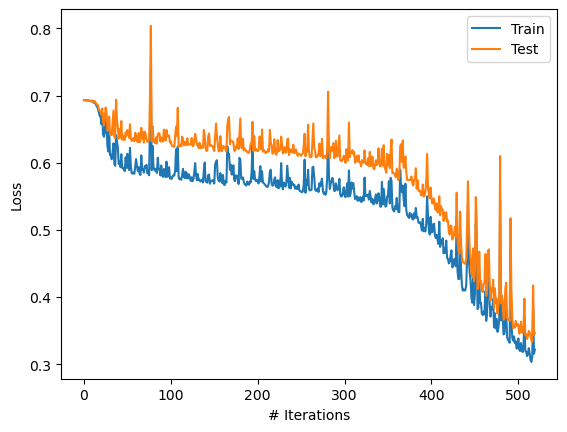

In [32]:
fig, ax = plt.subplots()

plt.plot(losses_train)
plt.plot(losses_test)

plt.ylabel("Loss")
plt.xlabel("# Iterations")
ax.legend(["Train", "Test"], loc="upper right");


* No apparent difference in training and test loss as the model is very small, thus overfitting is less of a concern. Loss is a little unstable because of the size of the model.

### Question 3

Now, we will attempt to distinguish all six languages from each other using deep learning.

**Question 3a:** Modify your model to support the six classes. Thus, at least the out-
put layer should be changed. Remember that this task is more difficult than in Question 2. You
may need to increase the network’s capacity slightly to achieve similar performance (e.g. adding layers
or increasing the number of neurons within the layers). In addition, consider the role of batch size and
learning rate.
**Question 3b:** What loss function is best suited for this task?.
**Question 3c:** Train the model for a few epochs (10 to 20). Provide a plot of a confusion matrix
of the model on the test set.
What do you observe? Is there something relevant that you can explain (In 100 words or less)?
**Question 3d:** Analyse the test set in your model’s output space using dimensionality
reduction. For this, we will be using a technique called PCA (principal component analysis).

we start with a simple architecture based on the previous question.



In [33]:
# Create the data set and dataloaders

config = {
    "batch_size": 16,
    "num_workers": 8,
    "learning_rate": 3e-4, # lower learning rate because the model is larger
    "num_epochs": 40,
}

num_workers = 0 if device == "cpu" else config["num_workers"]

X_train, X_test = np.expand_dims(X_train, axis=1), np.expand_dims(
    X_test, axis=1
)

train_dataset = TensorDataset(
    torch.from_numpy(X_train), torch.from_numpy(y_train)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test), torch.from_numpy(y_test)
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    drop_last=True,
    num_workers=0,
    pin_memory=True,
)


In [34]:
# Create the model

# increased depth of the network
n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
classifier_width = 128
cnn_layers = []
output_size = 6

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    loudness_normalization,
    normalization,
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
)
# No soft max as loss function expects logits

model = model.to(device)


In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# cross entropy + softmax
criterion = nn.CrossEntropyLoss().to(device)

In [36]:
def loss_accuracy(model, dataloader):
    with torch.no_grad():
        losses = []
        accuracies = []
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y = y.float()
            targets = F.one_hot(y.long(), num_classes=6).float()
            y_pred = model(X)
            losses.append(criterion(y_pred, targets).item())
            accuracies.append(y_pred.argmax(axis=1).round().eq(y).sum().item() / y.shape[0])
        return np.mean(losses), np.mean(accuracies)


In [37]:
losses_train = []
losses_test = []

for epoch in range(config["num_epochs"]):
    pbar = tqdm(train_dataloader)
    for i, batch in enumerate(pbar):
        optimizer.zero_grad()
        batch = [tensor.to(device) for tensor in batch]
        inputs = batch[0].to(device)
        targets = batch[1].float().to(device)

        output = model(inputs)
        # one hot encode targets
        targets = F.one_hot(targets.long(), num_classes=6).float()
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        # because the dataset is so small we can compute stats over the whole dataset
        if i % 100 == 0:
            loss_train, accuracy_train = loss_accuracy(model, train_dataloader)
            loss_test, accuracy_test = loss_accuracy(model, test_dataloader)
            losses_train.append(loss_train)
            losses_test.append(loss_test)

        pbar.set_description(
            f"accuracy: {accuracy_train:.3f}, test_accuracy: {accuracy_test:.3f}"
        )

accuracy: 0.946, test_accuracy: 0.607: 100%|██████████| 375/375 [00:14<00:00, 25.47it/s]


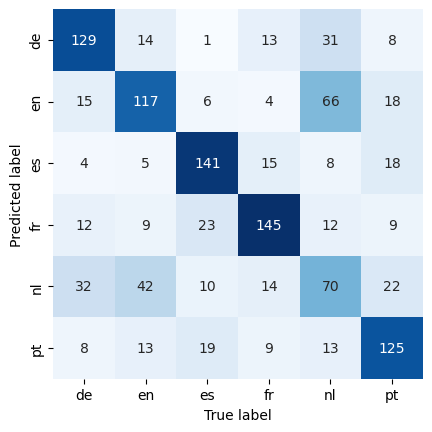

In [38]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


with torch.no_grad():
    y = []
    y_pred = []
    for batch in test_dataloader:
        X, y_batch = batch
        X = X.to(device)
        y_batch = y_batch.to(device)
        y_pred_batch = model(X).argmax(axis=1)
        y.extend(y_batch.cpu().numpy())
        y_pred.extend(y_pred_batch.cpu().numpy())

fig, ax = plt.subplots()

mat = confusion_matrix(y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, cmap="Blues")
ax.set_xlabel("True label")
ax.set_ylabel("Predicted label")
ax.set_xticklabels(languages)
ax.set_yticklabels(languages);

Dutch gets relatively often confused with English or German. This makes sense as all three are Germanic languages.
The model has some difficulty with seeing French as Spanish or Dutch.

In [39]:
# PCA plot of logits
from sklearn.decomposition import PCA

with torch.no_grad():
    y = []
    y_pred = []
    for batch in train_dataloader:
        X, y_batch = batch
        X = X.to(device)
        y_batch = y_batch.to(device)
        y_pred_batch = model(X)
        y.extend(y_batch.cpu().numpy())
        y_pred.extend(y_pred_batch.cpu().numpy())

y_pred = np.array(y_pred)

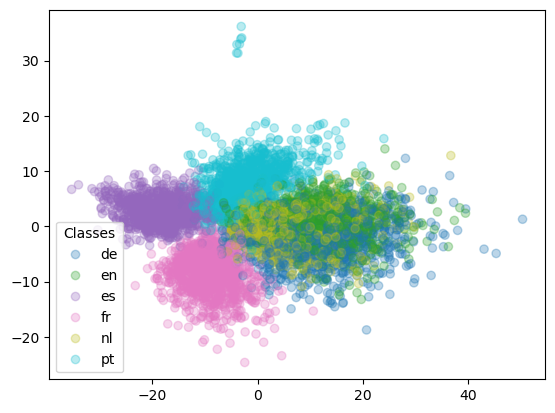

In [40]:
fig, ax = plt.subplots()
logits_pca = PCA(n_components=2).fit_transform(y_pred)
scatter = ax.scatter(*logits_pca.T, c=y, cmap="tab10", alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);

### Question 3, a more extensive approach

Here is an example of a better performing architecture.
This architecture uses diluted convolutions and is inspired by WaveNets,
see: https://www.youtube.com/watch?v=t3YJ5hKiMQ0


Notice that this models outperforms the previous one for the same amount of paramaters,
as it better captures the type of long-term relations found in audio.

In [46]:
"""
This file contains a simple implementation of a TCN model.
Options are limited to simplify the code.
"""
import torch.nn as nn
import torch
import numpy as np


class temporal_block(nn.Module):
    #Create a class that construct a block using dilated convolution and residual connections.
    
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(temporal_block, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size, dilation=dilation
        )
        self.batch_norm1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size, dilation=dilation
        )
        self.batch_norm2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = nn.Conv1d(in_channels, out_channels, 1)
        self.do_downsample = in_channels != out_channels
        padding = (kernel_size - 1) * dilation
        # causal padding
        self.padding = nn.ConstantPad1d((padding, 0), 0.0)
        self.pooling = nn.MaxPool1d(2)

    def forward(self, x):
        # x shape: (batch, channels, time)
        # y shape: (batch, channels, time)
        residual = x
        y = self.relu(self.batch_norm1(self.conv1(x)))
        y = self.padding(y)
        y = self.batch_norm2(self.conv2(y))
        y = self.padding(y)
        if self.do_downsample:
            residual = self.downsample(residual)
        y += residual
        y = self.pooling(self.relu(y))
        return y


class TCN(nn.Module):
    def __init__(
        self,
        n_conv_layers,
        n_classifier_layers,
        n_classes,
        classifier_width,
        starting_channels=16,
    ):
        super(TCN, self).__init__()

        # Convolutional part, with residual connections.
        channel_sizes = [1] + list(starting_channels * 2 ** np.arange(n_conv_layers))
        # convert to list of ints
        channel_sizes = [int(x) for x in channel_sizes]
        layers = []
        for i in range(n_conv_layers):
            layers.append(
                temporal_block(
                    channel_sizes[i], channel_sizes[i + 1], 3, dilation=2**i
                )
            )

        # take average features over time. In this way,
        # the model can be used for variable length inputs.
        layers += [nn.AdaptiveAvgPool1d(1), nn.Flatten()]
        # collapse all dimensions except batch
        layers += [nn.Flatten()]
        layers.append(nn.Linear(channel_sizes[-1], classifier_width))
        layers.append(nn.ReLU())

        for i in range(n_classifier_layers - 1):
            layers.append(nn.Linear(classifier_width, classifier_width))
            layers.append(nn.ReLU())

        # projection head, no activation
        # because our loss function expects unnormalized logits
        layers.append(nn.Linear(classifier_width, n_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch, channels, time)
        # y shape: (batch, n_classes)
        y = self.model(x)
        return y


In [48]:
n_classes = 6
model = TCN(
    n_conv_layers=5,
    n_classifier_layers=2,
    n_classes=n_classes,
    classifier_width=64,
    starting_channels=8,
)
model = nn.Sequential(loudness_normalization, normalization, model)
model.to(device);

In [49]:
summary(model, (1, 40_000))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
LoudnessNormalization-1             [-1, 1, 40000]               0
     Normalization-2             [-1, 1, 40000]               0
            Conv1d-3             [-1, 8, 39998]              32
       BatchNorm1d-4             [-1, 8, 39998]              16
              ReLU-5             [-1, 8, 39998]               0
     ConstantPad1d-6             [-1, 8, 40000]               0
            Conv1d-7             [-1, 8, 39998]             200
       BatchNorm1d-8             [-1, 8, 39998]              16
     ConstantPad1d-9             [-1, 8, 40000]               0
           Conv1d-10             [-1, 8, 40000]              16
             ReLU-11             [-1, 8, 40000]               0
        MaxPool1d-12             [-1, 8, 20000]               0
   temporal_block-13             [-1, 8, 20000]               0
           Conv1d-14            [-1,

In [50]:
config = {
    "batch_size": 16,
    "num_workers": 8,
    "learning_rate": 3e-4, # lower learning rate because the model is larger
    "num_epochs": 40,
}

optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# cross entropy + softmax
criterion = nn.CrossEntropyLoss().to(device)

In [52]:
losses_train = []
losses_test = []

for epoch in range(config["num_epochs"]):
    pbar = tqdm(train_dataloader)
    for i, batch in enumerate(pbar):
        optimizer.zero_grad()
        batch = [tensor.to(device) for tensor in batch]
        inputs = batch[0].to(device)
        targets = batch[1].float().to(device)

        output = model(inputs)
        # one hot encode targets
        targets = F.one_hot(targets.long(), num_classes=6).float()
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        # because the dataset is so small we can compute stats over the whole dataset
        if i % 100 == 0:
            loss_train, accuracy_train = loss_accuracy(model, train_dataloader)
            loss_test, accuracy_test = loss_accuracy(model, test_dataloader)
            losses_train.append(loss_train)
            losses_test.append(loss_test)

        pbar.set_description(
            f"accuracy: {accuracy_train:.3f}, test_accuracy: {accuracy_test:.3f}"
        )

  0%|          | 0/375 [00:01<?, ?it/s]


KeyboardInterrupt: 

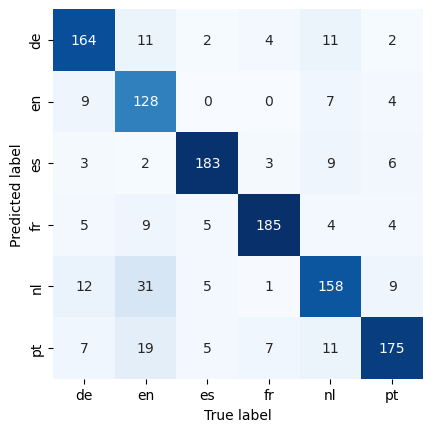

In [53]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


with torch.no_grad():
    y = []
    y_pred = []
    for batch in test_dataloader:
        X, y_batch = batch
        X = X.to(device)
        y_batch = y_batch.to(device)
        y_pred_batch = model(X).argmax(axis=1)
        y.extend(y_batch.cpu().numpy())
        y_pred.extend(y_pred_batch.cpu().numpy())

fig, ax = plt.subplots()

mat = confusion_matrix(y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, cmap="Blues")
ax.set_xlabel("True label")
ax.set_ylabel("Predicted label")
ax.set_xticklabels(languages)
ax.set_yticklabels(languages);

We can see that the Germanic languages are, on average, closer to eachother than the Latin Languages and vica versa.\
We can also see that Dutch is a hard Language for the model, as there is a lot of overlap with English and Portugese.